# LFP Analysis

## Tutorial overview

This Jupyter notebook will demonstrate how to access and analyze LFP data from the Neuropixels Visual Coding dataset. LFP, which stands for "local field potential," contains information about low-frequency (0.1-500 Hz) voltage fluctations around each recording site. It's complementary to the spiking activity, and can be analyzed on its own or in conjunction with spikes.

This tutorial will cover the following topics:

* <a href='#Learning-about-the-available-probes'>Selecting probes to analyze</a>
* <a href='#Loading-LFP-data'>Loading LFP data</a>
* <a href='#Aligning-LFP-data-to-a-stimulus'>Aligning data in time</a>
* <a href='#Aligning-LFP-data-to-units'>Aligning data in space</a>
* <a href='#Current-Source-Density'>Exploring pre-computed CSD plots</a>

This tutorial assumes you've already created a data cache, or are working with the files on AWS. If you haven't reached that step yet, we recommend going through the [data access tutorial](./ecephys_data_access.ipynb) first.

Functions related to analyzing spike data will be covered in other tutorials. For a full list of available tutorials, see the [SDK documentation](https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html).

Let's start by creating an `EcephysProjectCache` object, and pointing it to a new or existing manifest file:

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

If you're not sure what a manifest file is or where to put it, please check out [this tutorial](./ecephys_data_access.ipynb) before going further.

In [2]:
# Example cache directory path, it determines where downloaded data will be stored
data_directory = '/local1/ecephys_cache_dir/'

manifest_path = os.path.join(data_directory, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

Let's load the `sessions` table and grab the data for the first experiment in the list:

In [3]:
sessions = cache.get_session_table()

session = cache.get_session_data(sessions.index.values[0])

## Learning about the available probes

The `session` object contains all of the spike data for one recording session, as well as information about the stimulus, mouse behavior, and probes. To prevent the underlying NWB file from becoming too large, the LFP data is stored  separately, on a probe-by-probe basis. Before loading the LFP, let's take a look at the probes that are available for this session.

In [4]:
session.probes

,description,location,sampling_rate,lfp_sampling_rate,has_lfp_data
id,,,,,
810755797,probeA,See electrode locations,29999.954846,1249.998119,True
810755799,probeB,See electrode locations,29999.906318,1249.996097,True
810755801,probeC,See electrode locations,29999.985470,1249.999395,True
810755803,probeD,See electrode locations,29999.908100,1249.996171,True
810755805,probeE,See electrode locations,29999.985679,1249.999403,True
810755807,probeF,See electrode locations,30000.028033,1250.001168,True


There are six probes available, and all of them have LFP data. Note that there is a small subset of probes across the entire dataset that only have spike data, due to high levels of electrical noise contamining the LFP band. To see which sessions are missing LFP data, you can check the `probes` table from the `EcephysProjectCache`:

In [5]:
probes = cache.get_probes()

print('Fraction of probes with LFP: ' + str(np.around( np.sum(probes.has_lfp_data) / len(probes), 3) ) )
print(' ')
print('Sessions with missing LFP files: ' + str(list(probes[probes.has_lfp_data == False].ecephys_session_id.unique())))

Fraction of probes with LFP: 0.979
 
Sessions with missing LFP files: [763673393, 831882777, 839557629]


Returning to the current session, let's get some information about which brain regions each probe is recording from before we select LFP data to look at in more detail.

Each probe has a unique ID, but the "description" of each probe is assigned based on its location on the recording rig. The Allen Institute Neuropixels rigs have six slot for probes, which are named A, B, C, D, E, and F. The probes are arranged in a ring centered on visual cortex. Probe A is in the anterior/medial position, and the letters go clockwise around the ring.

To visualize what this looks like, we can access the spatial information in this session's `channels` table:

In [6]:
session.channels.keys()

Index(['probe_vertical_position', 'probe_horizontal_position', 'probe_id',
       'local_index', 'ecephys_structure_id', 'ecephys_structure_acronym',
       'anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate',
       'left_right_ccf_coordinate'],
      dtype='object')

As you can see, the `channels` table mainly contains columns related to the physical locations, either relative to the probe shank (`probe_vertical_position` and `probe_horizontal_position`), or relative to the Allen Common Coordinate Framework (`anterior_posterior_ccf_coordinate`, `dorsal_ventral_ccf_coordinate`, and `left_right_ccf_coordinate`). Let's use a combination of these to visualize the locations of the probes in this recording.

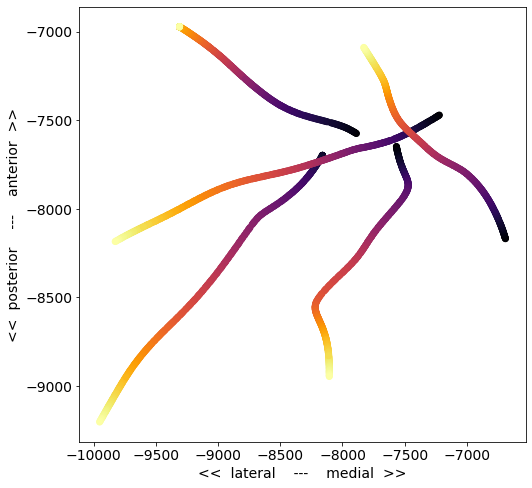

In [7]:
plt.rcParams.update({'font.size': 14})

x_coords = session.channels.left_right_ccf_coordinate
y_coords = session.channels.anterior_posterior_ccf_coordinate
color = session.channels.probe_vertical_position

plt.figure(figsize=(8,8))
_ = plt.scatter(-x_coords[x_coords > 0], -y_coords[x_coords > 0], c=color[x_coords > 0], cmap='inferno')
_ = plt.xlabel('<<  lateral    ---    medial  >>')
_ = plt.ylabel('<<  posterior    ---    anterior  >>')

This is a top-down view of the locations of each channel, with the color corresponding to distance along the probe axis (darker = deeper in the brain). A few things to note about this plot:

* There are only 5 probes visible, even though there were 6 probes in the recording. This is because one of the probes was not visible in the optical projection tomography volume we use to identify the recording location. If this occurs, the probe will be assigned a 3D CCF coordinate of [-1, -1, -1], and only cortical units will be given an `ecephys_structure_acronym`.
* The probe trajectories are curved, as a result of warping to the CCF template brain. The trajectories are straight in the original brain volume. 
* Some of the probes appear longer than others. This may be due to the viewing angle (in this plot, the more lateral probes are viewed more perpendicular to the insertion axis), or the fact that probes may be inserted to different depths.

To figure out which probe is missing, we can check the `probes` table for this session:

In [8]:
session.probes.loc[np.unique(session.channels.probe_id.values[x_coords > 0])].description.values

array(['probeA', 'probeC', 'probeD', 'probeE', 'probeF'], dtype=object)

It looks like `probeB` was not registered to the CCF. That means that `probeA` is in the upper right, `probeC` is in the lower right, and `D`, `E`, and `F` go clockwise from there. It's helpful to keep these descriptions in mind, because probes with the same descriptions enter the brain at roughly the same angle across experiments. Although the precise target point for each probe depends on the retinotopic map for each mouse, the overall rig geometry remains the same across sessions.

Let's look at the structures each of these probes passes through:

In [9]:
{session.probes.loc[probe_id].description : 
     list(session.channels[session.channels.probe_id == probe_id].ecephys_structure_acronym.unique())
     for probe_id in session.probes.index.values}

{'probeA': ['VISam', nan, 'APN', 'MB', 'DG', 'CA1'],
 'probeB': ['grey', nan, 'VISpm'],
 'probeC': ['PO', 'PoT', 'LP', 'DG', 'CA1', 'VISp', nan],
 'probeD': ['LGd', 'CA3', 'DG', 'CA1', 'VISl', nan],
 'probeE': ['PO', 'LP', 'LGd', 'CA3', 'DG', 'CA1', 'VISrl', nan],
 'probeF': ['CA1', 'VISrl', nan]}

In general, probes tend to be inserted through cortex (`VIS` structures), into to hippocampus (`CA1`, `CA3`, `DG`), and down into the thalamus or midbrain. If there's no CCF registration available (e.g., for `probeB` in this example), subcortical structures are marked as `grey`.

## Loading LFP data

Now that we've seen a general overview of how the probes are oriented and what structures they pass through, let's choose one and load its associated LFP data:

In [10]:
probe_id = session.probes[session.probes.description == 'probeE'].index.values[0]

lfp = session.get_lfp(probe_id)

If you haven't tried to access this data previously, you'll have to wait while the LFP NWB file downloads. Even if you already have the data stored locally, it may still take a minute to load, since the LFP data is quite large.

Once the data is loaded, we can take a closer look at the `lfp` object:

In [11]:
lfp

<xarray.DataArray 'LFP' (time: 12028993, channel: 95)>
array([[-2.43750e-05, -3.08100e-05, -3.19800e-05, ..., -1.95000e-07,
        -1.34550e-05, -1.15050e-05],
       [-4.44600e-05, -3.31500e-05, -1.42350e-05, ...,  1.95000e-06,
        -2.49600e-05, -1.34550e-05],
       [-4.58250e-05,  1.17000e-06, -1.42350e-05, ...,  1.36500e-06,
        -1.03350e-05, -1.71600e-05],
       ...,
       [-9.59400e-05, -1.54245e-04, -1.06275e-04, ...,  4.89450e-05,
         0.00000e+00,  4.09500e-06],
       [-1.93050e-05, -7.17600e-05, -4.25100e-05, ...,  6.10350e-05,
        -9.75000e-07,  1.15050e-05],
       [-2.73000e-05, -7.21500e-05, -6.24000e-05, ...,  3.04200e-05,
        -1.95000e-06, -1.95000e-07]], dtype=float32)
Coordinates:
  * time     (time) float64 13.58 13.58 13.58 ... 9.637e+03 9.637e+03 9.637e+03
  * channel  (channel) int64 850258492 850258500 ... 850259236 850259244

The LFP data is stored as an [xarray.DataArray](http://xarray.pydata.org/en/stable/) object, with coordinates of `time` and `channel`. The xarray library simplifies the process of working with N-dimensional data arrays, by keeping track of the meaning of each axis. If this is your first time encountering xarrays, we strongly recommend reading through the [documentation](http://xarray.pydata.org/en/stable/quick-overview.html) before going further. Getting used to xarrays can be frustrating, especially when they don't behave like numpy arrays. But they are designed to prevent common mistakes when analyzing multidimensional arrays, so they are well worth learning more about. Plus, the syntax is modeled on that of the [pandas](https://pandas.pydata.org/) library, so if you're familiar with that you already have a head start.

The print-out above already tells us a lot about what the `lfp` object contains. It stores an array with around 12 million points along the `time` axis and 95 points along the `channel` axis. The `time` axis ranges from 13.5 to around 9600 seconds, while the `channel` axis ranges from 850258492 to 850259244 (these are the unique IDs for each channel).

Let's use the `DataArray.sel()` method to select a slice through this array between 100 and 101 seconds:

In [12]:
lfp_slice = lfp.sel(time=slice(100,101))

lfp_slice

<xarray.DataArray 'LFP' (time: 1250, channel: 95)>
array([[ 1.50149994e-04,  1.49954998e-04,  1.65749996e-04, ...,
         4.68000007e-06,  2.30099995e-05, -1.13099995e-05],
       [ 1.64190002e-04,  1.41569995e-04,  1.50734995e-04, ...,
         6.62999992e-06,  1.18950002e-05, -1.30649996e-05],
       [ 1.43519996e-04,  1.47030005e-04,  1.80959993e-04, ...,
         4.48499986e-06,  1.96950004e-05,  8.18999979e-06],
       ...,
       [-2.35949992e-05, -1.63799996e-05, -3.45150002e-05, ...,
         1.55999999e-06, -1.48199997e-05, -1.11150002e-05],
       [-1.87200003e-05, -5.75249978e-05, -4.93349980e-05, ...,
         8.38500000e-06, -2.00849991e-05, -5.26499980e-06],
       [-3.17849990e-05, -5.53799982e-05, -4.17299998e-05, ...,
         2.14500005e-06, -1.67700000e-05, -2.73000001e-06]], dtype=float32)
Coordinates:
  * time     (time) float64 100.0 100.0 100.0 100.0 ... 101.0 101.0 101.0 101.0
  * channel  (channel) int64 850258492 850258500 ... 850259236 850259244

We see that this new DataArray is smaller than before; it contains the same number of channels, but only 1250 samples, due to the LFP sample rate of ~1250 Hz.

Let's plot the data for one of the channels:

Text(0, 0.5, 'LFP (V)')

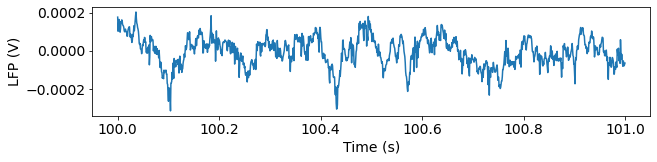

In [13]:
plt.figure(figsize=(10,2))
_ = plt.plot(lfp_slice.time, lfp_slice.sel(channel=lfp_slice.channel[10]))
plt.xlabel('Time (s)')
plt.ylabel('LFP (V)')

Alternatively, we can visualize this slice  of data using matplotlib's `imshow` method:

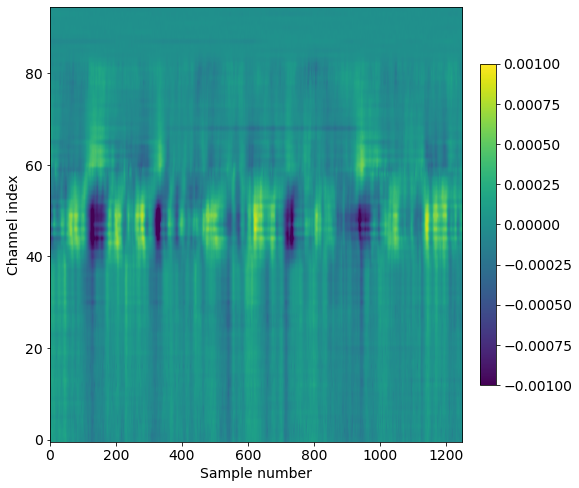

In [14]:
plt.figure(figsize=(8,8))
im = plt.imshow(lfp_slice.T,aspect='auto',origin='lower',vmin=-1e-3, vmax=1e-3)
_ = plt.colorbar(im, fraction=0.036, pad=0.04)
_ = plt.xlabel('Sample number')
_ = plt.ylabel('Channel index')

Note that we've transposed the original array to place the time dimension along the x-axis. We've also configured the plot so that the origin of the array is in the lower-left, so that that channels closer to the probe tip are lower in the image.

A few things to note about this plot:

* The units of the LFP are volts, so the color scale ranges from -1 to +1 mV
* Even though there are 384 channels on the Neuropixels probe, there are only 95 channels in this plot. That's because only every 4th channel is included in the NWB file (resulting in 40 micron vertical spacing). In addition, the reference channels and channels far outside the brain have been removed.
* The top of the plot is relatively flat. This corresponds to channels that are outside the brain. The LFP channels are originally referenced to a ground wire embedded in the ACSF/agarose mixture about cortex. Before NWB packaging, the LFP data is digitally referenced to the channels outside the brain, to remove noise that's shared across the whole probe.
* There's a large increase in LFP power toward the middle of the probe, which corresponds to channels in hippocampus.

Let's do some additional data selection to look at just the hippocampal channels from this recording.

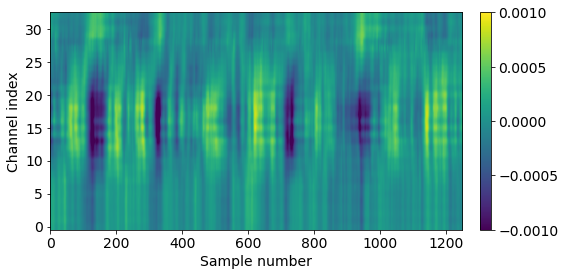

In [15]:
channel_ids = session.channels[(session.channels.probe_id == probe_id) & \
                 (session.channels.ecephys_structure_acronym.isin(['CA1','CA3','DG']))].index.values

lfp_slice2 = lfp_slice.sel(channel=slice(np.min(channel_ids), np.max(channel_ids)))

plt.figure(figsize=(8,4))
im = plt.imshow(lfp_slice2.T,aspect='auto',origin='lower',vmin=-1e-3, vmax=1e-3)
_ = plt.colorbar(im, fraction=0.036, pad=0.04)
_ = plt.xlabel('Sample number')
_ = plt.ylabel('Channel index')

<div style="padding: 40px; background: #FFE0F4">

### Suggestions for further analysis

* Can you use supervised learning to train a model to accurately identify brain regions based on LFP signals alone? What happens when you use this model to classify brain regions in recordings without CCF registration?

</div>

## Aligning LFP data to a stimulus

In the above example, we selected LFP data based on an arbitrary time span (100 to 101 seconds). For many analyses, however, you'll want to align the data to the onset of a particular type of stimulus.

The AllenSDK provides a number of convenience functions for aligning spikes to visual stimuli. We are planning to implement similar functions for LFP data in the near future. Until then, the steps below will show you how to perform this alignment.

First, we need to select some stimulus presentations to use:

In [16]:
presentation_table = session.stimulus_presentations[session.stimulus_presentations.stimulus_name == 'flashes']

presentation_times = presentation_table.start_time.values
presentation_ids = presentation_table.index.values

Now, we can align the LFP to these presentation times using some xarray magic:

In [17]:
trial_window = np.arange(-0.5, 0.5, 1/500)
time_selection = np.concatenate([trial_window + t for t in presentation_times])

inds = pd.MultiIndex.from_product((presentation_ids, trial_window), 
                                  names=('presentation_id', 'time_from_presentation_onset'))

ds = lfp.sel(time = time_selection, method='nearest').to_dataset(name = 'aligned_lfp')
ds = ds.assign(time=inds).unstack('time')

aligned_lfp = ds['aligned_lfp']

`aligned_lfp` is a DataArray with dimensions of channels x trials x time. It's been downsampled to 500 Hz by changing the time step in the `trial_window` variable.

Because we're using xarrays, the alignment operation is fast, and doesn't require any `for` loops! There's a lot going on here, so we recommend referring to the pandas and xarray documentation if anything is confusing.

Now we can visualize the average LFP, aligned to the trial onset:

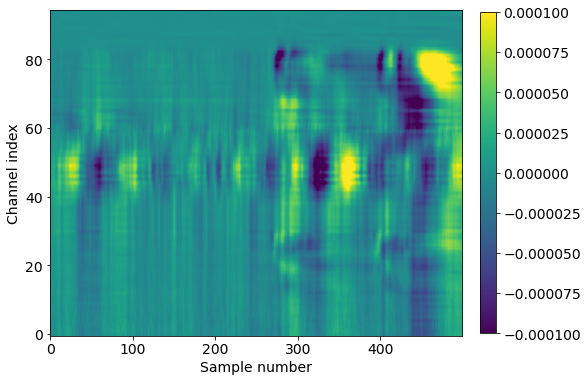

In [18]:
plt.figure(figsize=(8,6))
im = plt.imshow(aligned_lfp.mean(dim='presentation_id'), aspect='auto', origin='lower', vmin=-1e-4, vmax=1e-4)
_ = plt.colorbar(im, fraction=0.036, pad=0.04)
_ = plt.xlabel('Sample number')
_ = plt.ylabel('Channel index')

Here we see the effect of a 250 ms flash stimulus on the LFP. There are two large responses in cortex (channel index 60-80), one corresponding to the stimulus onset (around sample 280), and one corresponding to the stimulus offset (around sample 400).

Note that the voltage range is an order of magnitude less than it was for the single-trial LFP, around -100 to +100 microvolts.

You can use the code sample above to align the LFP to any type of event (e.g. spike times, running onset, optogenetic stimuli) just by changing the `trial_window` and `time_selection` variables.

<div style="padding: 40px; background: #FFE0F4">

### Suggestions for further analysis

* How do the time delays of stimulus-evoked LFP deflections vary across areas and depths? Are these delays different for different stimulus conditions?

* Are there consistent patterns in the LFP when aligning to the start of running, or the onset of an eye movement?

</div>

## Aligning LFP data to units

The previous section demonstrated how to align the LFP in time. What if we want to extract the LFP at a particular location in space, corresponding to the location of a unit we're analyzing?

Let's start by finding a well-isolated, high-firing rate unit in visual cortex from the probe we're currently working with. For more information about using quality metrics to assess unit isolation quality, check out [this tutorial](./ecephys_quality_metrics.ipynb).

Once we've selected a unit of interest, the xarray library makes it easy to find the associated LFP channel.

In [19]:
units_of_interest = session.units[(session.units.probe_id == probe_id) &
                                  (session.units.ecephys_structure_acronym.str.find('VIS') > -1) &
                                  (session.units.firing_rate > 10) & 
                                  (session.units.nn_hit_rate > 0.95)]
                                  
len(units_of_interest)

/home/nicholas.mei/miniconda3/envs/allensdk/lib/python3.7/site-packages/allensdk/brain_observatory/ecephys/ecephys_project_api/ecephys_project_warehouse_api.py:291: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  pv_is_bool = np.issubdtype(output["p_value_rf"].values[0], np.bool)


4

There are four units that meet our criteria. Let's choose one and find its associated channel index.

In [20]:
unit_id = units_of_interest.index.values[0]

channel_index = units_of_interest.loc[unit_id].channel_local_index

channel_index

260

Note that this is the channel index relative to the original probe (out of 384 possible channels), rather than the index of the LFP DataArray.

We can now use the channel index to find the unique channel ID for this unit:

In [21]:
channel_id = session.channels[(session.channels.local_index == channel_index) & 
                              (session.channels.probe_id == probe_id)].index.values[0]

channel_id

850259008

Using `unit_id` and `channel_id`, we can select the spikes and LFP within an arbitrary time interval. Note that we need to use `method='nearest'` when selecting the LFP data channel, since not every electrode is included in the LFP DataArray.

In [22]:
start_time = 500
end_time = 510

spike_times = session.spike_times[unit_id]

times_in_range = spike_times[(spike_times > start_time) & (spike_times < end_time)]

lfp_data = lfp.sel(time = slice(start_time, end_time))
lfp_data = lfp_data.sel(channel = channel_id, method='nearest')

/home/nicholas.mei/miniconda3/envs/allensdk/lib/python3.7/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:1093: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',"


Finally, we can plot the spike times along with the LFP for this interval:

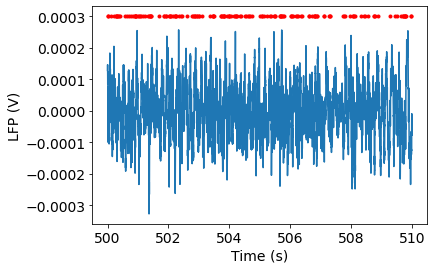

In [23]:
_ = plt.plot(lfp_data.time, lfp_data)
_ = plt.plot(times_in_range, np.ones(times_in_range.shape)*3e-4, '.r')
_ = plt.xlabel('Time (s)')
_ = plt.ylabel('LFP (V)')

<div style="padding: 40px; background: #FFE0F4">

### Suggestions for further analysis

* What does the spike-triggered LFP look like for different units? Is it possible to classify units based on the properties of the spike-triggered LFP?

* How well can you predict spike rates from the nearby LFP signals? Does this vary across different brain regions?

</div>

## Current Source Density

LFP data is commonly used to generate current source density (CSD) plots, which show the location of current sources and sinks along the probe axis. CSD analysis benefits from high spatial resolution, since it involves taking the second spatial derivative of the data. Because of Neuropixels dense site spacing, these probes are optimal for computing the CSD. However, the LFP data available through the AllenSDK has been spatially downsampled prior to NWB packaging.

To provide access to a high-resolution CSD plot, we've pre-computed the CSD in response to a flash stimulus for all probes with LFP.

In [24]:
csd = session.get_current_source_density(probe_id)
csd

<xarray.DataArray 'CSD' (virtual_channel_index: 384, time: 875)>
array([[  58327.03371574,   20117.6298887 ,  -14617.79294315, ...,
        -179410.38257756, -140541.81597896,  -99855.52022176],
       [ -65434.3204571 ,  -32932.62888488,   -3367.24904473, ...,
         161433.08930627,  136244.74051173,  109671.1407354 ],
       [  28505.59773412,   31288.43801342,   33892.68350592, ...,
          39946.37351702,   24588.34919833,    8571.48977541],
       ...,
       [  -3201.28149464,   -1289.03683893,     502.04419085, ...,
           -943.9933153 ,   -2669.37931577,   -4375.39738216],
       [ -32827.35201643,  -16409.56190898,   -1052.05581321, ...,
        -106129.85783238,  -94380.54770586,  -82251.01882374],
       [  34153.87655675,   16950.77633742,     815.89811501, ...,
          94579.10700446,   89217.81476538,   83741.3728981 ]])
Coordinates:
  * virtual_channel_index  (virtual_channel_index) int64 0 1 2 3 ... 381 382 383
  * time                   (time) float64 -0.1 -0.0996 -0.0992 ... 0.2492 0.2496
    vertical_position      (virtual_channel_index) float64 0.0 10.0 ... 3.83e+03
    horizontal_position    (virtual_channel_index) float64 24.0 24.0 ... 24.0

The `CSD` object is a DataArray with dimensions of channels x time. Note that the channels are actually "virtual channels," based on interpolated signals along the central axis of the probe, with 10 micron inter-site spacing.

<Figure size 720x720 with 0 Axes>

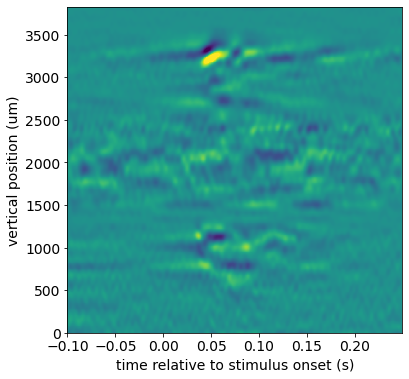

In [25]:
from scipy.ndimage.filters import gaussian_filter

_ = plt.figure(figsize=(10,10))

filtered_csd = gaussian_filter(csd.data, sigma=(5,1))

fig, ax = plt.subplots(figsize=(6, 6))

_ = ax.pcolor(csd["time"], csd["vertical_position"], filtered_csd, vmin=-3e4, vmax=3e4)

_ = ax.set_xlabel("time relative to stimulus onset (s)")
_ = ax.set_ylabel("vertical position (um)")

This CSD shows a clear stimulus-evoked response in cortex (2600-3500 microns), with an even earlier response in a subcortical region (700-1200 microns).

We can use the `channels` table to figure out where this signal is coming from:

In [26]:
list(session.channels[(session.channels.probe_id == probe_id) &
                 (session.channels.probe_vertical_position > 700) &
                 (session.channels.probe_vertical_position < 1200)].ecephys_structure_acronym.unique())

['LP', 'LGd']

It looks like this region of the probe is on the border between LGd and LP nuclei in the thalamus.

<div style="padding: 40px; background: #FFE0F4">

### Suggestions for further analysis

* How does the cortical CSD vary across visual areas? Are there consistent patterns across all areas?

* Are the locations of sources and sinks correlated with other features of the LFP, such as power in different frequency bands? 

</div>